In [1]:
import numpy as np
import numpy.matlib as mlt
import mne
import statistics 
from pathlib import Path
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import pandas as pd
from mne.filter import filter_data 
%matplotlib inline
mne.set_log_level('CRITICAL')

Code snippet for file processing, example of using below.

In [2]:
def microvolts_to_volts(value):
    """
    Since openBCI writes data into micro volts and mne works with volts we
    will need to convert the data later.
    :param value: single micro volts value
    :return: same value in volts
    """
    return float(value) / 1000


def load_openbci_file(filename, ch_names=None, skiprows=0, max_rows=0):
    """
    Load data from OpenBCI file into mne RawArray for later use
    :param filename: filename for reading in form of relative path from working directory
    :param ch_names: dictionary having all or some channels like this:
            {"fp1":1, "fp2":2, "c3":3, "c4":4, "o1":5, "o2":6, "p3":7, "p4":8}
            Key specifies position on head using 10-20 standard and
            Value referring to channel number on Cyton BCI board
    :return: RawArray class of mne.io library
    """
    if ch_names is None:
        ch_names = {"fp1":1, "fp2":2, "c3":3, "c4":4, "o1":5, "o2":6, "p3":7, "p4":8}

    # Converter of BCI file to valuable data
    converter = {i: (microvolts_to_volts if i < 12 else lambda x: str(x).split(".")[1][:-1])
                 for i in range(0, 13)}

    info = mne.create_info(
        ch_names=list(ch_names.keys()),
        ch_types=['eeg' for i in range(0, len(ch_names))],
        sfreq=250,
        montage='standard_1020'
    )
    data = np.loadtxt(filename, comments="%", delimiter=",",
                      converters=converter, skiprows=skiprows, max_rows=max_rows).T
    data = data[list(ch_names.values())]
    data = filter_data(data, 250, l_freq=2, h_freq=50)
#     print ('data type', type(data), '  shape  ' , data.shape)
    return mne.io.RawArray(data, info)


def create_epochs(raw_data, duration=1):
    """
    Chops the RawArray onto Epochs given the time duration of every epoch
    :param raw_data: mne.io.RawArray instance
    :param duration: seconds for copping
    :return: mne Epochs class
    """
    events = mne.make_fixed_length_events(raw_data, duration=duration)
    epochs = mne.Epochs(raw_data, events, preload=True)
    return epochs

def create_epochs_with_baseline(raw_data, baseline, duration=1):
    """
    Chops the RawArray onto Epochs given the time duration of every epoch
    :param raw_data: mne.io.RawArray instance
    :param duration: seconds for copping
    :return: mne Epochs class
    """
    events = mne.make_fixed_length_events(raw_data, duration=duration)
    epochs = mne.Epochs(raw_data, events, preload=True, baseline=baseline)
    return epochs


def get_files(dir='.', pattern='*.txt'):
    """
    Loading files from given directory with specified pattern.
    :param dir: Lookup directory
    :param pattern: Pattern for files. Default *.txt for loading raw BCI files
    :return: array of file paths
    """
    # Specifying files directory, select all the files from there which is txt
    datadir = Path(dir).glob(pattern)
    # Transferring generator into array of file paths
    return [x for x in datadir]

In [3]:
def get_sample_data(path, regx, skiprow=10000, max_row=133000):
    files = get_files(path, regx)
    ch_names = {"fp2":1, "fp1":2, "f4":3, "f3":4, "c4":5, "c3":6, "o2":7, "o1":8}
    raw_data = []
    raw_baselines = []
#     file = files[-1]
#     print(file)
#     raw_data.append(load_openbci_file(file, ch_names=ch_names, skiprows=skiprow, max_rows=max_row))
    
#     return create_epochs(raw_data[0])  
    
    for file in files:
        raw_data.append(load_openbci_file(file, ch_names=ch_names, skiprows=skiprow, max_rows=max_row))
        baseline_subj = str(file).split('_')[2]
        baseline_sess = str(file).split('_')[3]
        raw_baselines.append( '*' + baseline_subj + '*' + baseline_sess + '*Baseline*')
        
    real_data_series = [create_epochs(raw) for raw in raw_data]
    return real_data_series, raw_baselines

Defining Constants 

In [4]:
 # TAKE ONE RANDOM RECORDING FOR PLOTTING
n_channels = 8
SAMPLE_FREQ = 250

Next applying ICA and print the filters.

Note: Filter ID may not be the same as channel ID.


In [5]:
def transform_ICA(sample_data):
    ica = ICA()
    ica.fit(sample_data)
    return ica.apply(sample_data) # Transform recording into ICA space

# Convert data into vector
Try different approaches. Next is an attempt to see overall recording waves.
Free to change everything next.

In [6]:
def remove_epochs(data_epochs):
    dat = data_epochs.get_data()
    data = np.zeros( (dat.shape[0] * dat.shape[2], 8) )
    n_epoch = len(dat)
    n_in_epoch = dat.shape[2]
    for i in range(n_epoch):
        data[i*n_in_epoch:i*n_in_epoch + n_in_epoch] = dat[i].T
    
    return data

In [7]:
def build_table(data):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/SAMPLE_FREQ)
    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)

    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")
    return df

In [8]:
# table_of_coding.iloc[2, 1] / table_of_coding.iloc[4, 1]

In [9]:
# table_of_coding

In [10]:
def vectorize(sample_data, waves1='Alpha', waves2='Gamma'):
    vector = []
    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}
    
    
    ch_names = {"fp2":0, "fp1":1, "f4":2, "f3":3, "c4":4, "c3":5, "o2":6, "o1":7}
    
    
    analysis_data = np.zeros( (sample_data.shape[0], sample_data.shape[1]//2, sample_data.shape[2]) )
    i = 0
    
    # Calculate hemisphere difference ratio left / right
    for sample_epoch in sample_data:
        analysis_data[i][0] = (sample_epoch[1] - sample_epoch[0]) / (sample_epoch[1] + sample_epoch[0])
        analysis_data[i][1] = (sample_epoch[3] - sample_epoch[2]) / (sample_epoch[3] + sample_epoch[2])
        analysis_data[i][2] = (sample_epoch[5] - sample_epoch[4]) / (sample_epoch[5] + sample_epoch[4])
        analysis_data[i][3] = (sample_epoch[7] - sample_epoch[6]) / (sample_epoch[7] + sample_epoch[6])
        i+=1
    
#     vector = np.zeros((i,1))
    for epoch in analysis_data:
    
     # Get real amplitudes of FFT (only in postive frequencies)
        fft_vals = np.absolute(np.fft.rfft(epoch.T))

        # Get frequencies for amplitudes in Hz
        fft_freq = np.fft.rfftfreq(len(epoch.T), 1.0/SAMPLE_FREQ)
        eeg_band_fft = dict()
    
        for band in eeg_bands:
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                               (fft_freq <= eeg_bands[band][1]))[0]
            eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    
        vector.append(eeg_band_fft[waves1] / eeg_band_fft[waves2])

    return np.array(vector)

In [11]:
def apply_absolute_baseline(data, baseline):
    baseline = vectorize(baseline)
    baseline = mlt.repmat(baseline, 1, int(np.ceil(len(data)/len(baseline))))[0]
    base = baseline[:len(data)]
#     print('Base shape', base.shape)
#     print('Data shape', data.shape)
    data = data.reshape(9, int(np.ceil(len(data)/9)))
    base = base.reshape(9, int(np.ceil(len(base)/9)))
#     print('Base shape', base.shape)
#     print('Data shape', data.shape)
    data = np.mean(data.T, axis=1)
    base = np.mean(base.T, axis=1)
#     print('Base shape', base.shape)
#     print('Data shape', data.shape)
    
    return data - base

In [12]:
def compare_baseline(subj_data, subj_name):
    base = get_files('Dataset/', subj_name)
    print(base)
    ch_names = {"fp2":1, "fp1":2, "f4":3, "f3":4, "c4":5, "c3":6, "o2":7, "o1":8}
    base = load_openbci_file(base[0], ch_names=ch_names, skiprows=1000, max_rows=20000)
    base = create_epochs(base).get_data()
    
    subj_data = vectorize(subj_data.get_data())
    base = vectorize(base)
    base = mlt.repmat(base, 1, int(np.ceil(len(subj_data)/len(base))))[0]
    base = base[:len(subj_data)]
    
    return spatial.distance.euclidean(subj_data, base)

In [13]:
def do_baseline(subj_data, subj_name):
    base = get_files('Dataset/', subj_name)
    ch_names = {"fp2":1, "fp1":2, "f4":3, "f3":4, "c4":5, "c3":6, "o2":7, "o1":8}
    base = load_openbci_file(base[0], ch_names=ch_names, skiprows=1000, max_rows=20000)
    base = create_epochs(base).get_data()
    
    subj_data = vectorize(subj_data.get_data())
    
#     print(base.shape)
#     print(subj7_data.shape)

    return apply_absolute_baseline(subj_data, base)
    

In [14]:
from sklearn.preprocessing import normalize
from scipy import spatial 

In [51]:
raw_codings, baselines = get_sample_data('Dataset/', '*Session1*Coding.*')

In [52]:
mean = 0
means = []
del raw_codings[1]
del raw_codings[1]
del raw_codings[1]

del baselines[1]
del baselines[1]
del baselines[1]

for datas in zip(raw_codings, baselines):
    data = transform_ICA(datas[0])
    compared = compare_baseline(data, datas[1])
    means.append(compared)
    mean += compared
    
print(mean / len(raw_codings))

[WindowsPath('Dataset/OpenBCI-RAW-2019-06-14_13-06-50_Subject9_Session1_Baseline.txt')]
[WindowsPath('Dataset/OpenBCI-RAW-2019-06-26_10-13-58_Subject17_Session1_Baseline.txt')]
[WindowsPath('Dataset/OpenBCI-RAW-2019-06-26_20-37-49_Subject7_Session1_Baseline.txt')]
248.8195412611641


In [35]:
raw_codingmeds, baselines = get_sample_data('Dataset/', '*Session2*Codingmed*')

In [36]:
mean_codemed = 0
meanscm = []
for datas in zip(raw_codingmeds, baselines):
    data = transform_ICA(datas[0])
    compared = compare_baseline(data, datas[1])
    meanscm.append(compared)
    mean_codemed += compared

print(mean_codemed / len(raw_codingmeds))

[WindowsPath('Dataset/OpenBCI-RAW-2019-06-17_19-03-41_Subject11_Session2_Baseline.txt')]
190.3834848516326


In [37]:
raw_codings2, baselines = get_sample_data('Dataset/', '*Session2*Coding.*')

In [38]:
mean_codeses2 = 0
means2 = []
for datas in zip(raw_codings2, baselines):
    data = transform_ICA(datas[0])
    compared = compare_baseline(data, datas[1])
    means2.append(compared)
    mean_codeses2 += compared
    
print(mean_codeses2 / len(raw_codings2))

[WindowsPath('Dataset/OpenBCI-RAW-2019-06-06_21-33-31_Subject7_Session2_Baseline.txt')]
[WindowsPath('Dataset/OpenBCI-RAW-2019-06-08_19-13-48_Subject8_Session2_Baseline.txt')]
[WindowsPath('Dataset/OpenBCI-RAW-2019-06-15_14-14-29_Subject9_Session2_Baseline.txt')]
312.1653154998669


In [39]:
raw_meds, baselines = get_sample_data('Dataset/', '*Session2*Meditation*')

In [40]:
mean_medit = 0
medmeans = []
for datas in zip(raw_meds, baselines):
    data = transform_ICA(datas[0])
    compared = compare_baseline(data, datas[1])
    medmeans.append(compared)
    mean_medit += compared
    
print(mean_medit / len(raw_meds))

[WindowsPath('Dataset/OpenBCI-RAW-2019-06-17_19-03-41_Subject11_Session2_Baseline.txt')]
241.2497604007325


In [86]:
from scipy import stats
print(means)
print(meanscm)
print(means2)
print(medmeans)

[515.5456330112872, 187.00209281312814, 43.91089795907696]
[190.3834848516326]
[258.5692619520419, 269.2432399574976, 408.6834445900611]
[241.2497604007325]


ValueError: `bins` must increase monotonically, when an array

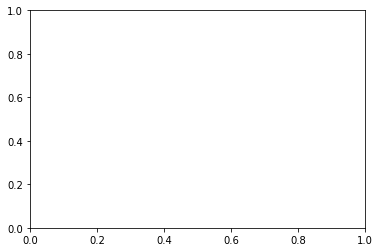

In [84]:
coding1 = 248.8195412611641
codingmed = 190.3834848516326
coding2 = 312.1653154998669

legend = ['Coding 1', 'Coding 2', 'Meditation + Coding']
xaxs = np.linspace(0, 100, 3)

plt.hist([coding1, coding2, codingmed])